In [1]:
from itertools import combinations

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3

from utils import (
    logging,
    TARGET_PROTEIN,
    SAMPLE_END_DATE,
    MUTATION_PER_SEQ_FILE,
    FIXATION_LINKAGE_FILE,
    RECOMMENDED_MUTATIONS_FILE
)

combo_min_num = 2
score_threshold = 0


In [2]:
logging.info("Load data...")

df: pd.DataFrame = pd.read_feather(MUTATION_PER_SEQ_FILE)
df["Date"] = pd.to_datetime(df["Date"])

df = df[df["Mutation"].str.contains(TARGET_PROTEIN)]
df = df[~df["Mutation"].str.contains("stop")]
df = df[~df["Mutation"].str.contains("ins")]
df["AA"] = df["Mutation"].str.split("_").str[1].str[1:]

future_df = df[df["Date"] >= SAMPLE_END_DATE]
df = df[df["Date"] < SAMPLE_END_DATE]

fixation_linkage = pd.read_csv(FIXATION_LINKAGE_FILE)
aa_combo: pd.DataFrame = pd.read_feather(RECOMMENDED_MUTATIONS_FILE)
aa_combo = aa_combo[aa_combo["Accession"].str.contains(TARGET_PROTEIN)]


In [3]:
known_muts = set(df["AA"].unique())
all_possible_mut_combo = set(
    (frozenset(i) for i in combinations(known_muts, combo_min_num))
)
len(all_possible_mut_combo)


4450636

In [4]:
existing_combo = []

ac_group: pd.DataFrame
for ac, ac_group in df.groupby("Accession", sort=False):
    if len(ac_group.index) >= combo_min_num:
        existing_combo.extend(
            (frozenset(i)
             for i in combinations(ac_group["AA"].values, combo_min_num))
        )

existing_combo = set(existing_combo)
assert len(existing_combo.difference(all_possible_mut_combo)) == 0

len(existing_combo)


13978

In [5]:
recommended_combo = []

mut_group: pd.DataFrame
for mut, mut_group in aa_combo.groupby("Accession", sort=False):
    mut = mut.split("_")[1][1:]
    mut_group = mut_group[mut_group["Score"] > score_threshold]
    mutated = (mut_group["Pos"].astype(str) + mut_group["AA"]).values
    recommended_combo.extend(
        (frozenset((mut, i)) for i in mutated if i != mut)
    )

recommended_combo = set(recommended_combo).difference(existing_combo)
len(recommended_combo)


3176462

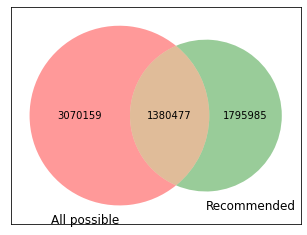

In [6]:
venn2(
    [all_possible_mut_combo, recommended_combo],
    ("All possible", "Recommended")
)
plt.gca().set_facecolor('white')
plt.gca().set_axis_on()
plt.savefig("plots/venn_graph.pdf", bbox_inches="tight")

In [7]:
fixation_combo = []

fix_group: pd.DataFrame
for fix, fix_group in fixation_linkage.groupby("label", sort=False):
    muts = set(m.split("_")[1][1:] for m in fix.split(","))
    muts = muts.intersection(known_muts)
    if len(muts) >= combo_min_num:
        fixation_combo.extend(
            (frozenset(i) for i in combinations(muts, combo_min_num))
        )

fixation_combo = set(fixation_combo).difference(existing_combo)
assert len(fixation_combo.difference(all_possible_mut_combo)) == 0

len(fixation_combo)


32

In [8]:
len(recommended_combo.intersection(fixation_combo))

8

In [9]:
len(fixation_combo.difference(recommended_combo))

24

In [ ]:
# future_combo = []

# ac_group: pd.DataFrame
# for ac, ac_group in future_df.groupby("Accession", sort=False):
#     if len(ac_group.index) >= combo_min_num:
#         future_combo.extend(
#             (frozenset(i)
#              for i in combinations(ac_group["AA"].values, combo_min_num))
#         )

# future_combo = set(future_combo).difference(existing_combo)
# assert len(future_combo.difference(all_possible_mut_combo)) == 0

# len(future_combo)


In [ ]:
# len(recommended_combo.intersection(future_combo))

In [ ]:
# len(future_combo.difference(recommended_combo))